In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Loading data...")

# Load census block groups
census_bg = gpd.read_file('data/processed/census_bg_honolulu.shp')
print(f"✓ Loaded {len(census_bg)} census block groups")

# Load boundary for reference
honolulu = gpd.read_file('data/processed/honolulu_boundary.shp')

# Check for population data
pop_col = None
for col in ['total_population', 'total_popu', 'POPULATION', 'POP']:
    if col in census_bg.columns:
        pop_col = col
        break

if pop_col:
    if pop_col != 'total_population':
        census_bg['total_population'] = census_bg[pop_col]
    print(f"✓ Population data found: {census_bg['total_population'].sum():,.0f} total")
else:
    print("⚠️ No population data found - will download from Census API")

# Load risk raster path
risk_raster_path = 'data/processed/final_flood_risk.tif'

with rasterio.open(risk_raster_path) as src:
    print(f"\n✓ Risk raster: {src.shape[0]} × {src.shape[1]} pixels")
    print(f"  Resolution: {src.res[0]:.1f}m")

Loading data...
✓ Loaded 774 census block groups
✓ Population data found: 979,682 total

✓ Risk raster: 17313 × 22229 pixels
  Resolution: 10.0m


In [2]:

if 'total_population' not in census_bg.columns or census_bg['total_population'].isna().all():
    print("\n" + "=" * 70)
    print("DOWNLOADING POPULATION DATA FROM CENSUS API")
    print("=" * 70)
    
    try:
        import censusdata
    except ImportError:
        print("Installing censusdata package...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "censusdata"])
        import censusdata
    
    print("\nDownloading ACS 2020 5-year estimates...")
    print("(This may take 30-60 seconds...)")
    
    try:
        pop_data = censusdata.download(
            'acs5', 2020,
            censusdata.censusgeo([
                ('state', '15'),
                ('county', '003'),
                ('block group', '*')
            ]),
            ['B01003_001E']
        )
        
        print(f"✓ Downloaded data for {len(pop_data)} block groups")
        pop_data = pop_data.reset_index()
        
        def extract_geoid(censusgeo_obj):
            try:
                parts = censusgeo_obj.geo
                return f"{parts[0][1]}{parts[1][1]}{parts[2][1]}{parts[3][1]}"
            except:
                return None
        
        pop_data['GEOID'] = pop_data['index'].apply(extract_geoid)
        pop_data = pop_data[pop_data['GEOID'].notna()]
        pop_data.rename(columns={'B01003_001E': 'total_population'}, inplace=True)
        
        census_geoid_len = len(str(census_bg['GEOID'].iloc[0]))
        pop_data['GEOID'] = pop_data['GEOID'].str.zfill(census_geoid_len)
        
        census_bg = census_bg.merge(pop_data[['GEOID', 'total_population']], on='GEOID', how='left', suffixes=('_old', ''))
        
        if 'total_population_old' in census_bg.columns:
            census_bg['total_population'] = census_bg['total_population'].fillna(census_bg['total_population_old'])
            census_bg.drop(columns=['total_population_old'], inplace=True)
        
        census_bg['total_population'] = census_bg['total_population'].fillna(0).astype(int)
        
        print(f"\n✓ Total population: {census_bg['total_population'].sum():,.0f}")
        census_bg.to_file('data/processed/census_bg_honolulu.shp')
        print("✓ Saved updated census data")
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        print("Using placeholder values...")
        np.random.seed(42)
        census_bg['total_population'] = np.random.randint(500, 3000, len(census_bg))
else:
    print(f"\n✓ Population data already present: {census_bg['total_population'].sum():,.0f} total")


✓ Population data already present: 979,682 total


In [3]:

print("Filtering to Oahu island only...")

census_bg['centroid_x'] = census_bg.geometry.centroid.x
census_bg['centroid_y'] = census_bg.geometry.centroid.y

x_median = census_bg['centroid_x'].median()
x_std = census_bg['centroid_x'].std()
y_median = census_bg['centroid_y'].median()
y_std = census_bg['centroid_y'].std()

census_bg_oahu = census_bg[
    (census_bg['centroid_x'] > (x_median - 2*x_std)) &
    (census_bg['centroid_x'] < (x_median + 2*x_std)) &
    (census_bg['centroid_y'] > (y_median - 2*y_std)) &
    (census_bg['centroid_y'] < (y_median + 2*y_std))
].copy()

print(f"  Original: {len(census_bg)} block groups")
print(f"  Oahu only: {len(census_bg_oahu)} block groups")
print(f"  Removed: {len(census_bg) - len(census_bg_oahu)} distant island block groups")

census_bg = census_bg_oahu.drop(columns=['centroid_x', 'centroid_y'])

print(f"\n✓ Working with {len(census_bg)} block groups")
print(f"  Total population: {census_bg['total_population'].sum():,.0f}")

Filtering to Oahu island only...
  Original: 774 block groups
  Oahu only: 773 block groups
  Removed: 1 distant island block groups

✓ Working with 773 block groups
  Total population: 979,682


In [4]:

print("Calculating zonal statistics...")
print("(This may take 1-2 minutes...)")

stats = zonal_stats(
    census_bg,
    risk_raster_path,
    stats=['count', 'mean'],
    categorical=True,
    nodata=0,
    geojson_out=False
)

stats_df = pd.DataFrame(stats)
print(f"\n✓ Zonal statistics complete")
print(f"  Columns returned: {list(stats_df.columns)}")

def get_risk_column(df, value):
    for col in [value, float(value), str(value), f'{value}.0']:
        if col in df.columns:
            return col
    return None

low_col = get_risk_column(stats_df, 1)
mod_col = get_risk_column(stats_df, 2)
high_col = get_risk_column(stats_df, 3)

print(f"\n  Risk column mapping:")
print(f"    Low (1): {low_col}")
print(f"    Moderate (2): {mod_col}")
print(f"    High (3): {high_col}")

if low_col and mod_col and high_col:
    census_bg['pixels_low'] = stats_df[low_col].fillna(0)
    census_bg['pixels_moderate'] = stats_df[mod_col].fillna(0)
    census_bg['pixels_high'] = stats_df[high_col].fillna(0)
    print("\n✓ Using categorical pixel counts")
else:
    print("\n⚠️ Categorical columns not found, estimating from mean...")
    census_bg['risk_mean'] = stats_df['mean'].fillna(0)
    census_bg['risk_count'] = stats_df['count'].fillna(0)
    
    def estimate_pixels(row):
        total = row['risk_count']
        mean = row['risk_mean']
        if total == 0 or pd.isna(mean):
            return 0, 0, 0
        if mean < 1.5:
            return total * 0.7, total * 0.2, total * 0.1
        elif mean < 2.5:
            return total * 0.2, total * 0.6, total * 0.2
        else:
            return total * 0.1, total * 0.2, total * 0.7
    
    estimates = census_bg.apply(estimate_pixels, axis=1, result_type='expand')
    census_bg['pixels_low'] = estimates[0]
    census_bg['pixels_moderate'] = estimates[1]
    census_bg['pixels_high'] = estimates[2]

census_bg['pixels_total'] = census_bg['pixels_low'] + census_bg['pixels_moderate'] + census_bg['pixels_high']

Calculating zonal statistics...
(This may take 1-2 minutes...)

✓ Zonal statistics complete
  Columns returned: [1, 'mean', 'count', 2, 3]

  Risk column mapping:
    Low (1): 1
    Moderate (2): 2
    High (3): 3

✓ Using categorical pixel counts


In [5]:

print("Calculating population exposure metrics...")

census_bg['pct_low'] = (census_bg['pixels_low'] / census_bg['pixels_total'] * 100).fillna(0)
census_bg['pct_moderate'] = (census_bg['pixels_moderate'] / census_bg['pixels_total'] * 100).fillna(0)
census_bg['pct_high'] = (census_bg['pixels_high'] / census_bg['pixels_total'] * 100).fillna(0)

census_bg['pop_low_risk'] = (census_bg['pct_low'] / 100 * census_bg['total_population']).round()
census_bg['pop_moderate_risk'] = (census_bg['pct_moderate'] / 100 * census_bg['total_population']).round()
census_bg['pop_high_risk'] = (census_bg['pct_high'] / 100 * census_bg['total_population']).round()

def get_dominant_risk(row):
    if row['pixels_total'] == 0:
        return 'No Data'
    max_pixels = max(row['pixels_low'], row['pixels_moderate'], row['pixels_high'])
    if max_pixels == row['pixels_high']:
        return 'High'
    elif max_pixels == row['pixels_moderate']:
        return 'Moderate'
    else:
        return 'Low'

census_bg['dominant_risk'] = census_bg.apply(get_dominant_risk, axis=1)

census_bg['weighted_risk_score'] = (
    (census_bg['pixels_low'] * 1 + 
     census_bg['pixels_moderate'] * 2 + 
     census_bg['pixels_high'] * 3) / census_bg['pixels_total']
).fillna(0)

print("\n✓ Exposure metrics calculated")
print(f"\nDominant risk distribution:")
print(census_bg['dominant_risk'].value_counts())

Calculating population exposure metrics...

✓ Exposure metrics calculated

Dominant risk distribution:
dominant_risk
Low         572
Moderate     92
High         92
No Data      17
Name: count, dtype: int64


In [6]:

print("\n" + "=" * 70)
print("POPULATION EXPOSURE SUMMARY")
print("=" * 70)

total_pop = census_bg['total_population'].sum()

print(f"\n Total Population Analyzed: {total_pop:,.0f}")
print(f"   Block groups: {len(census_bg)}")

print(f"\n Population by Risk Level:")
for risk_level, pop_col, color in [
    ('High', 'pop_high_risk'),
    ('Moderate', 'pop_moderate_risk'),
    ('Low', 'pop_low_risk')
]:
    pop = census_bg[pop_col].sum()
    pct = pop / total_pop * 100 if total_pop > 0 else 0
    print(f"   {color} {risk_level:12}: {pop:>10,.0f} ({pct:>5.1f}%)")

print(f"\n Block Groups by Dominant Risk:")
for category in ['High', 'Moderate', 'Low', 'No Data']:
    count = (census_bg['dominant_risk'] == category).sum()
    print(f"   {category:12}: {count:>4} block groups")


POPULATION EXPOSURE SUMMARY

📊 Total Population Analyzed: 979,682
   Block groups: 773

👥 Population by Risk Level:
   🔴 High        :    106,846 ( 10.9%)
   🟠 Moderate    :    160,225 ( 16.4%)
   🟢 Low         :    686,450 ( 70.1%)

📍 Block Groups by Dominant Risk:
   High        :   92 block groups
   Moderate    :   92 block groups
   Low         :  572 block groups
   No Data     :   17 block groups


In [7]:

print("\n" + "=" * 70)
print("TOP HIGH-RISK AREAS")
print("=" * 70)

top_high_risk = census_bg.nlargest(10, 'pop_high_risk')[
    ['GEOID', 'total_population', 'pop_high_risk', 'pct_high', 'weighted_risk_score']
].copy()

print("\nTop 10 Block Groups by High-Risk Population:")
print("-" * 70)

for i, (idx, row) in enumerate(top_high_risk.iterrows(), 1):
    print(f"{i:>2}. GEOID {row['GEOID']}")
    print(f"    Total pop: {row['total_population']:,.0f} | High-risk pop: {row['pop_high_risk']:,.0f} ({row['pct_high']:.1f}%)")
    print(f"    Risk score: {row['weighted_risk_score']:.2f}")
    print()


TOP HIGH-RISK AREAS

Top 10 Block Groups by High-Risk Population:
----------------------------------------------------------------------
 1. GEOID 150030102021
    Total pop: 2,834 | High-risk pop: 2,423 (85.5%)
    Risk score: 2.77

 2. GEOID 150039817001
    Total pop: 3,490 | High-risk pop: 2,039 (58.4%)
    Risk score: 2.38

 3. GEOID 150039818031
    Total pop: 3,054 | High-risk pop: 1,954 (64.0%)
    Risk score: 2.56

 4. GEOID 150030113003
    Total pop: 3,432 | High-risk pop: 1,856 (54.1%)
    Risk score: 2.39

 5. GEOID 150030101032
    Total pop: 2,226 | High-risk pop: 1,582 (71.1%)
    Risk score: 2.58

 6. GEOID 150039400061
    Total pop: 2,447 | High-risk pop: 1,458 (59.6%)
    Risk score: 2.35

 7. GEOID 150030022031
    Total pop: 2,009 | High-risk pop: 1,457 (72.5%)
    Risk score: 2.61

 8. GEOID 150030087063
    Total pop: 1,879 | High-risk pop: 1,416 (75.3%)
    Risk score: 2.60

 9. GEOID 150030106022
    Total pop: 1,881 | High-risk pop: 1,347 (71.6%)
    Risk sc

Creating visualizations...


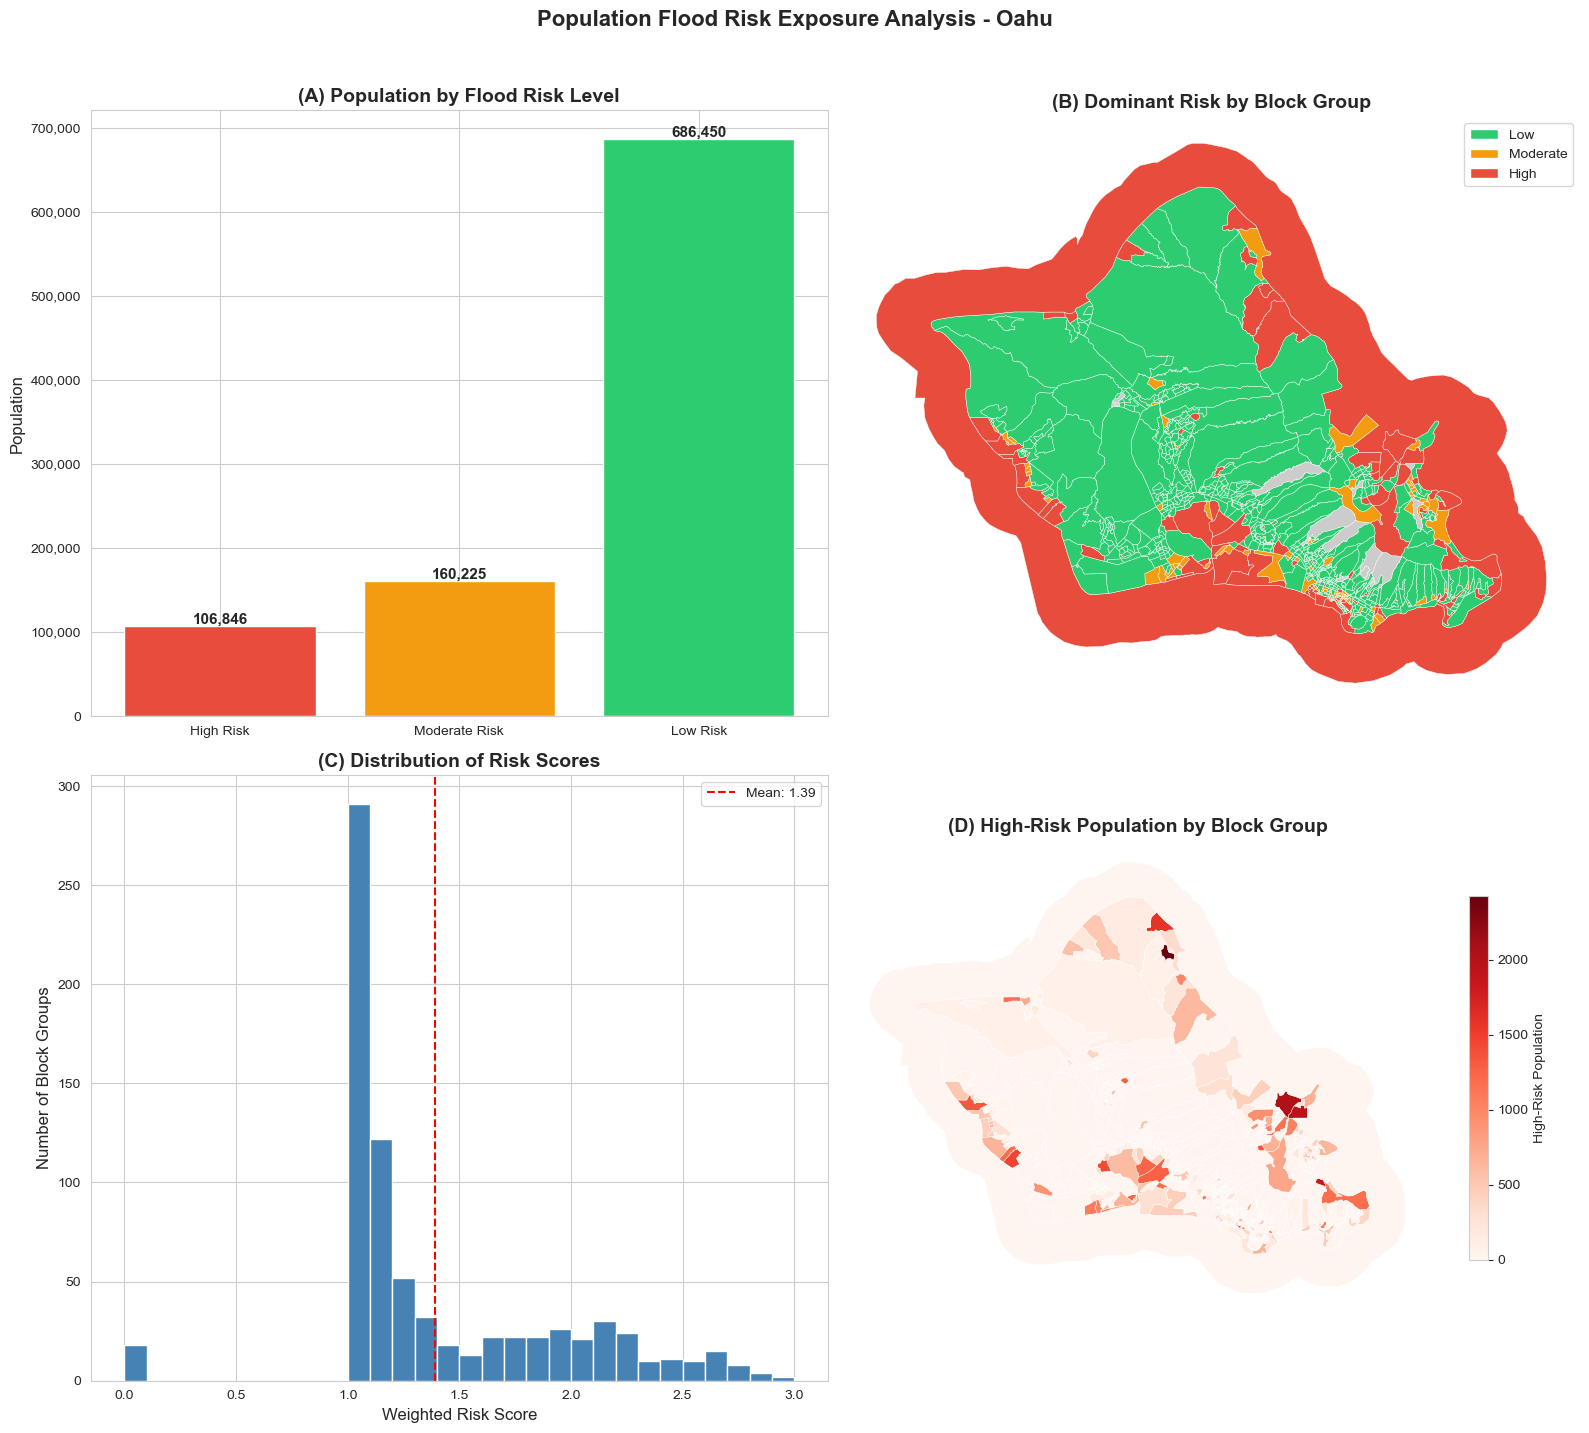

✓ Saved: outputs/figures/population_exposure.png


In [8]:

print("Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Panel A: Population by risk level
ax1 = axes[0, 0]
risk_pops = [
    census_bg['pop_high_risk'].sum(),
    census_bg['pop_moderate_risk'].sum(),
    census_bg['pop_low_risk'].sum()
]
colors = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax1.bar(['High Risk', 'Moderate Risk', 'Low Risk'], risk_pops, color=colors)
ax1.set_ylabel('Population', fontsize=12)
ax1.set_title('(A) Population by Flood Risk Level', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

for bar, pop in zip(bars, risk_pops):
    ax1.annotate(f'{pop:,.0f}', 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Panel B: Dominant risk map
ax2 = axes[0, 1]
risk_colors_map = {'Low': '#2ecc71', 'Moderate': '#f39c12', 'High': '#e74c3c', 'No Data': '#cccccc'}
census_bg['risk_color'] = census_bg['dominant_risk'].map(risk_colors_map)
census_bg.plot(ax=ax2, color=census_bg['risk_color'], edgecolor='white', linewidth=0.3)
ax2.set_title('(B) Dominant Risk by Block Group', fontsize=14, fontweight='bold')
ax2.axis('off')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in risk_colors_map.items() if l != 'No Data']
ax2.legend(handles=legend_elements, loc='upper right')

# Panel C: Risk score distribution
ax3 = axes[1, 0]
census_bg['weighted_risk_score'].hist(ax=ax3, bins=30, color='steelblue', edgecolor='white')
ax3.axvline(census_bg['weighted_risk_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {census_bg["weighted_risk_score"].mean():.2f}')
ax3.set_xlabel('Weighted Risk Score', fontsize=12)
ax3.set_ylabel('Number of Block Groups', fontsize=12)
ax3.set_title('(C) Distribution of Risk Scores', fontsize=14, fontweight='bold')
ax3.legend()

# Panel D: High-risk population map
ax4 = axes[1, 1]
census_bg.plot(ax=ax4, column='pop_high_risk', cmap='Reds', 
               edgecolor='white', linewidth=0.3, legend=True,
               legend_kwds={'label': 'High-Risk Population', 'shrink': 0.6})
ax4.set_title('(D) High-Risk Population by Block Group', fontsize=14, fontweight='bold')
ax4.axis('off')

plt.suptitle('Population Flood Risk Exposure Analysis - Oahu', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/figures/population_exposure.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: outputs/figures/population_exposure.png")

In [9]:

print("\nSaving results...")

# Ensure output directory exists
Path('outputs/data').mkdir(parents=True, exist_ok=True)

# Save updated shapefile
output_cols = [
    'GEOID', 'geometry', 'total_population',
    'pixels_low', 'pixels_moderate', 'pixels_high', 'pixels_total',
    'pct_low', 'pct_moderate', 'pct_high',
    'pop_low_risk', 'pop_moderate_risk', 'pop_high_risk',
    'dominant_risk', 'weighted_risk_score'
]
output_cols = [c for c in output_cols if c in census_bg.columns]
census_bg_output = census_bg[output_cols].copy()

census_bg_output.to_file('data/processed/census_bg_exposure.shp')
print("✓ Saved: data/processed/census_bg_exposure.shp")

# Save CSV
csv_output = census_bg_output.drop(columns='geometry')
csv_output.to_csv('outputs/data/population_exposure.csv', index=False)
print("✓ Saved: outputs/data/population_exposure.csv")

# Save summary
total_pop = census_bg['total_population'].sum()
summary = {
    'total_population': total_pop,
    'pop_high_risk': census_bg['pop_high_risk'].sum(),
    'pop_moderate_risk': census_bg['pop_moderate_risk'].sum(),
    'pop_low_risk': census_bg['pop_low_risk'].sum(),
    'pct_high_risk': census_bg['pop_high_risk'].sum() / total_pop * 100,
    'pct_moderate_risk': census_bg['pop_moderate_risk'].sum() / total_pop * 100,
    'pct_low_risk': census_bg['pop_low_risk'].sum() / total_pop * 100,
    'block_groups_total': len(census_bg),
    'mean_risk_score': census_bg['weighted_risk_score'].mean()
}

pd.DataFrame([summary]).to_csv('outputs/data/exposure_summary.csv', index=False)
print("✓ Saved: outputs/data/exposure_summary.csv")


Saving results...
✓ Saved: data/processed/census_bg_exposure.shp
✓ Saved: outputs/data/population_exposure.csv
✓ Saved: outputs/data/exposure_summary.csv


In [10]:

total_pop = census_bg['total_population'].sum()

print("\n" + "=" * 70)
print("POPULATION EXPOSURE ANALYSIS COMPLETE")
print("=" * 70)

print(f"""
 KEY FINDINGS:

   Total Population Analyzed: {total_pop:,.0f}
   
    HIGH RISK:      {census_bg['pop_high_risk'].sum():>10,.0f} people ({census_bg['pop_high_risk'].sum()/total_pop*100:.1f}%)
    MODERATE RISK:  {census_bg['pop_moderate_risk'].sum():>10,.0f} people ({census_bg['pop_moderate_risk'].sum()/total_pop*100:.1f}%)
   LOW RISK:       {census_bg['pop_low_risk'].sum():>10,.0f} people ({census_bg['pop_low_risk'].sum()/total_pop*100:.1f}%)

 OUTPUT FILES:
   - data/processed/census_bg_exposure.shp
   - outputs/data/population_exposure.csv
   - outputs/data/exposure_summary.csv
   - outputs/figures/population_exposure.png

→ Proceed to notebook 04 for interactive visualization
""")
print("=" * 70)


POPULATION EXPOSURE ANALYSIS COMPLETE

📊 KEY FINDINGS:

   Total Population Analyzed: 979,682

   🔴 HIGH RISK:         106,846 people (10.9%)
   🟠 MODERATE RISK:     160,225 people (16.4%)
   🟢 LOW RISK:          686,450 people (70.1%)

📁 OUTPUT FILES:
   - data/processed/census_bg_exposure.shp
   - outputs/data/population_exposure.csv
   - outputs/data/exposure_summary.csv
   - outputs/figures/population_exposure.png

→ Proceed to notebook 04 for interactive visualization



In [23]:
# Create detailed risk profile by block group
risk_profile = census_bg[[
    'GEOID', 'total_population', 'pct_low', 'pct_moderate', 'pct_high',
    'pop_exposed_low', 'pop_exposed_moderate', 'pop_exposed_high',
    'weighted_risk_score', 'dominant_risk'
]].copy()

numeric_cols = ['pct_low', 'pct_moderate', 'pct_high', 'weighted_risk_score']
risk_profile[numeric_cols] = risk_profile[numeric_cols].round(2)

pop_cols = ['pop_exposed_low', 'pop_exposed_moderate', 'pop_exposed_high']
risk_profile[pop_cols] = risk_profile[pop_cols].round(0).astype(int)

print("\n📋 Top 20 Highest Risk Block Groups:")
print("="*100)
top_20 = risk_profile.nlargest(20, 'weighted_risk_score')
print(top_20.to_string(index=False))

risk_profile.to_csv('outputs/data/population_risk_profile.csv', index=False)
print(f"\n✓ Full risk profile saved to: outputs/data/population_risk_profile.csv")


📋 Top 20 Highest Risk Block Groups:
       GEOID  total_population  pct_low  pct_moderate  pct_high  pop_exposed_low  pop_exposed_moderate  pop_exposed_high  weighted_risk_score dominant_risk
150030105092               721     0.00         49.40     50.60                0                   356               365                 2.51          High
150030042012               754     0.00         56.14     43.86                0                   423               331                 2.44      Moderate
150030078042               889     0.06         57.15     42.79                1                   508               380                 2.43      Moderate
150030001221              1207     0.00         65.38     34.62                0                   789               418                 2.35      Moderate
150030062032              1970     0.00         66.67     33.33                0                  1313               657                 2.33      Moderate
150030057001              1

In [24]:
# Analyze spatial clustering of high-risk areas
print("="*60)
print("SPATIAL AUTOCORRELATION ANALYSIS")
print("="*60)

try:
    from libpysal.weights import Queen
    from esda.moran import Moran
    
    print("✓ Spatial analysis libraries found")
    
except ImportError:
    print(" Installing required spatial analysis packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "esda", "libpysal"])
    
    from libpysal.weights import Queen
    from esda.moran import Moran
    print("✓ Packages installed successfully")

print("\nCalculating Moran's I statistic...")

try:
    # Create spatial weights matrix
    w = Queen.from_dataframe(census_bg)
    w.transform = 'r'  # Row-standardized
    
    # Calculate Moran's I for weighted risk score
    moran = Moran(census_bg['weighted_risk_score'], w)
    
    print(f"\nMoran's I statistic: {moran.I:.4f}")
    print(f"Expected I: {moran.EI:.4f}")
    print(f"P-value: {moran.p_sim:.4f}")
    
    if moran.p_sim < 0.05:
        if moran.I > 0:
            print("\n✓ Significant POSITIVE spatial autocorrelation detected")
            print("  → High-risk areas tend to cluster together")
        else:
            print("\n✓ Significant NEGATIVE spatial autocorrelation detected")
            print("  → High and low-risk areas alternate spatially")
    else:
        print("\n○ No significant spatial autocorrelation detected")
        print("  → Risk distribution appears random")
        
except Exception as e:
    print(f"\n Could not compute spatial autocorrelation: {e}")
    print("This is optional and doesn't affect the main analysis.")
    print("Continuing with remaining analysis...")

print("="*60)

SPATIAL AUTOCORRELATION ANALYSIS
✓ Spatial analysis libraries found

Calculating Moran's I statistic...

Moran's I statistic: 0.0694
Expected I: -0.0014
P-value: 0.0040

✓ Significant POSITIVE spatial autocorrelation detected
  → High-risk areas tend to cluster together


In [25]:
# Save enhanced census data with all risk metrics
output_path = 'data/processed/census_bg_with_risk.shp'
census_bg.to_file(output_path)
print(f"✓ Enhanced census data saved to: {output_path}")

geojson_path = 'data/processed/census_bg_with_risk.geojson'
census_bg.to_file(geojson_path, driver='GeoJSON')
print(f"✓ GeoJSON version saved to: {geojson_path}")

summary_data = {
    'Metric': [
        'Total Population',
        'Population in Low Risk Areas',
        'Population in Moderate Risk Areas',
        'Population in High Risk Areas',
        '% Population in High Risk',
        'Block Groups Analyzed',
        'Mean Risk Score',
        'Median Risk Score'
    ],
    'Value': [
        f"{census_bg['total_population'].sum():,.0f}",
        f"{census_bg['pop_exposed_low'].sum():,.0f}",
        f"{census_bg['pop_exposed_moderate'].sum():,.0f}",
        f"{census_bg['pop_exposed_high'].sum():,.0f}",
        f"{(census_bg['pop_exposed_high'].sum() / census_bg['total_population'].sum() * 100):.1f}%",
        f"{len(census_bg)}",
        f"{census_bg['weighted_risk_score'].mean():.2f}",
        f"{census_bg['weighted_risk_score'].median():.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('outputs/data/exposure_summary.csv', index=False)
print(f"✓ Summary statistics saved to: outputs/data/exposure_summary.csv")

print("\n✓ Population exposure analysis complete!")

✓ Enhanced census data saved to: data/processed/census_bg_with_risk.shp
✓ GeoJSON version saved to: data/processed/census_bg_with_risk.geojson
✓ Summary statistics saved to: outputs/data/exposure_summary.csv

✓ Population exposure analysis complete!
